In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.dknn_attack_l2 import DKNNL2Attack
from lib.dknn_attack_linf import DKNNLinfAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNNL2
from lib.utils import *
from lib.lip_model import *

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
exp_id = 0

model_name = 'train_mnist_exp%d.h5' % exp_id
net = BasicModel()

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# # net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=128)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'lip_mnist_exp%d.h5' % exp_id
# net = LipschitzModel()

# model_name = 'dist_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# net = NeighborModel(num_classes=10, init_it=init_it, train_it=train_it)

# model_name = 'adv_mnist_exp%d.h5' % exp_id
# basic_net = BasicModel()
# # basic_net = BasicModelV2()
# config = {'epsilon': 0.3,
#           'num_steps': 40,
#           'step_size': 0.01,
#           'random_start': True,
#           'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

# model_name = 'lipae_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# latent_dim = 128
# alpha = 1e2
# net = NCA_AE(latent_dim=latent_dim, init_it=init_it,
#              train_it=train_it, alpha=alpha)

# orig_model = 'adv_mnist_exp2.h5'
# model_name = 'tune%d_%s' % (exp_id, orig_model)
# net = BasicModel()
# from tune_mnist import Identity
# net.fc = Identity()

# model_name = 'rot_mnist_exp%d.h5' % exp_id
# net = BasicModel(num_classes=4)

# model_name = 'adv_rot_mnist_exp%d.h5' % exp_id
# basic_net = BasicModel(num_classes=4)
# config = {'num_steps': 20,
#           'step_size': 0.05,
#           'random_start': True,
#           'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

# model_name = 'ae_mnist_exp%d.h5' % exp_id
# net = Autoencoder((1, 28, 28), 128)

# model_name = 'adv_mnist_ae_exp%d.h5' % exp_id
# basic_net = Autoencoder((1, 28, 28), latent_dim=128)
# config = {'num_steps': 40,
#               'step_size': 0.1,
#               'random_start': True,
#               'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

In [7]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
# net = net.basic_net
net.eval()

NameError: name 'model_name' is not defined

In [8]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [7]:
y_pred = net(x_test.to(device))

In [8]:
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.7778

In [18]:
# Use to substitute a model with kNN on pixel space
# so that it is compatible with DkNN and DkNN attack

# class Identity(nn.Module):

#     def __init__(self):
#         super(Identity, self).__init__()

#     def forward(self, x):
#         return x
    
# net.conv1 = Identity()
# net.relu1 = Identity()
# net.conv2 = Identity()
# net.relu2 = Identity()
# net.conv3 = Identity()
# net.relu3 = Identity()
# net.fc = Identity()

In [7]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
layers = ['relu3']
# layers = ['relu1']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#             k=75, num_classes=10)
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [8]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9653


In [17]:
cred = dknn.credibility(y_pred)

(array([ 947., 1119.,  809.,  953.,  545.,  869.,    0.,    0.,    0.,
        4758.]),
 array([0.0265 , 0.12385, 0.2212 , 0.31855, 0.4159 , 0.51325, 0.6106 ,
        0.70795, 0.8053 , 0.90265, 1.     ]),
 <a list of 10 Patch objects>)

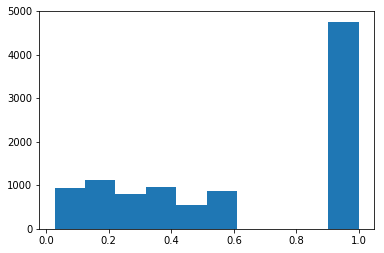

In [18]:
plt.hist(cred)

In [21]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

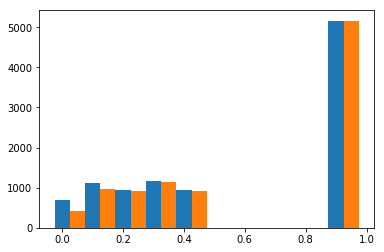

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [15]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.52764613, 0.83124478, 0.94539249, 0.98878343, 0.99498495,
              nan,        nan,        nan,        nan, 0.99922103])

In [45]:
dknn.A.mean()

0.17333333333333334

In [154]:
nn = dknn.get_neighbors(x_valid)

In [15]:
for (D, I) in nn:
    print(D[-1].mean())

0.72602546
0.6874378
0.7105881
0.94844836


---

## DkNN Attack

In [ ]:
# Attack for cosine DkNN

attack = DKNNAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=75, binary_search_steps=1,
            max_iterations=500, learning_rate=1e-1, 
            initial_const=1e3, abort_early=True, max_linf=0.4)
    return x_adv

num = 10
x_adv = attack_batch(x_test[:num].cuda(), y_test[:num], 10)

In [9]:
# Attack for L2 DkNN

attack = DKNNL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=1, binary_search_steps=10,
            max_iterations=500, learning_rate=1e-1, guide=1,
            initial_const=1e-1, abort_early=True, random_start=False)
    return x_adv

num = 100
x_adv = attack_batch(x_test[:num].cuda(), y_test[:num], 100)

    step: 0; loss: 14.295; l2dist: 0.000
    step: 50; loss: 11.650; l2dist: 0.690
    step: 100; loss: 11.627; l2dist: 0.682
    step: 150; loss: 11.627; l2dist: 0.681
tensor(3., device='cuda:0')
binary step: 0; number of successful adv: 3/100
    step: 0; loss: 139.504; l2dist: 0.000
    step: 50; loss: 108.569; l2dist: 1.208
    step: 100; loss: 107.942; l2dist: 1.006
    step: 150; loss: 107.746; l2dist: 0.931
    step: 200; loss: 107.695; l2dist: 0.911
    step: 250; loss: 107.700; l2dist: 0.912
tensor(2., device='cuda:0')
binary step: 1; number of successful adv: 3/100
    step: 0; loss: 1393.375; l2dist: 0.000
    step: 50; loss: 1061.530; l2dist: 1.503
    step: 100; loss: 1059.926; l2dist: 1.437
    step: 150; loss: 1058.928; l2dist: 1.367
    step: 200; loss: 1058.057; l2dist: 1.312
    step: 250; loss: 1057.512; l2dist: 1.270
    step: 300; loss: 1057.121; l2dist: 1.223
    step: 350; loss: 1056.797; l2dist: 1.196
    step: 400; loss: 1056.459; l2dist: 1.172
    step: 450; l

In [57]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
    print((y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() / y_pred.shape[0])

0.0

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

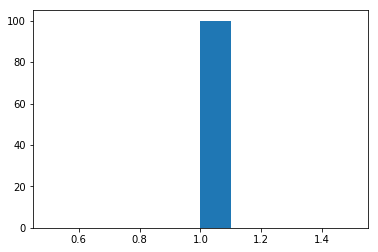

In [58]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

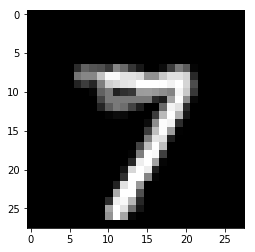

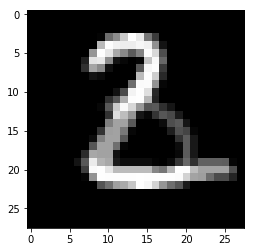

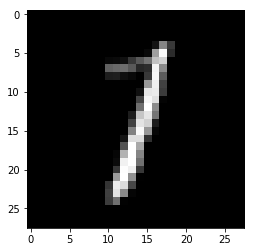

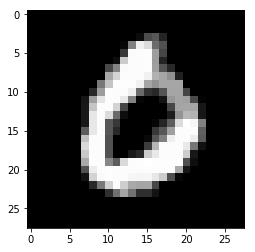

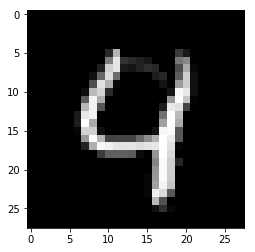

In [59]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

In [ ]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
    print((y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() / y_pred.shape[0])

In [ ]:
pert[ind_adv].mean()

## CW L2 Attack

without DkNN

In [37]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=10, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1e1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:100].cuda(), y_test[:100].cuda(), 100)

    step: 0; loss: 121.171; l2dist: 0.000
    step: 50; loss: 14.259; l2dist: 3.370
    step: 100; loss: 5.832; l2dist: 2.329
    step: 150; loss: 3.891; l2dist: 1.881
    step: 200; loss: 3.129; l2dist: 1.670
    step: 250; loss: 2.757; l2dist: 1.566
    step: 300; loss: 2.619; l2dist: 1.514
    step: 350; loss: 2.490; l2dist: 1.482
    step: 400; loss: 2.450; l2dist: 1.471
    step: 450; loss: 2.461; l2dist: 1.470
binary step: 0; number of successful adv: 95/100
    step: 0; loss: 125.270; l2dist: 0.000
    step: 50; loss: 12.968; l2dist: 3.178
    step: 100; loss: 5.455; l2dist: 2.202
    step: 150; loss: 3.782; l2dist: 1.809
    step: 200; loss: 3.111; l2dist: 1.636
    step: 250; loss: 2.797; l2dist: 1.551
    step: 300; loss: 2.592; l2dist: 1.506
    step: 350; loss: 2.498; l2dist: 1.478
    step: 400; loss: 2.428; l2dist: 1.462
    step: 450; loss: 2.420; l2dist: 1.455
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 72.985; l2dist: 0.000
    step: 50; loss: 

In [21]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test[:10000]).numpy().sum() / y_pred.size(0)

0.0

In [ ]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:10000].numpy()).sum() / len(y_pred)

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

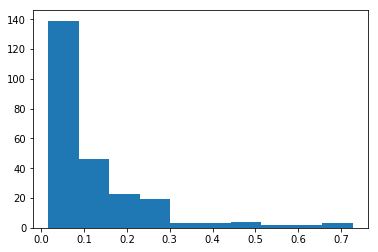

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:10000].numpy()
plt.hist(cred[suc_ind])

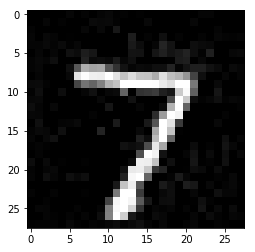

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [28]:
(x_adv.cpu() - x_test[:10000]).view(10000, -1).norm(2, 1).mean()

tensor(1.3970, grad_fn=<MeanBackward1>)

In [19]:
(x_adv.cpu() - x_test[:100]).view(100, -1).norm(2, 1).mean()

tensor(2.7167, grad_fn=<MeanBackward1>)

In [ ]:
x_adv = pickle.load(open('x_adv/x_adv_adv_cifar10_exp0.h5.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_ba_cifar10_adv2_0.2_0.001.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

In [38]:
torchvision.utils.save_image(x_adv[:15], 'mnist_cw_basic.png', nrow=15, padding=0)

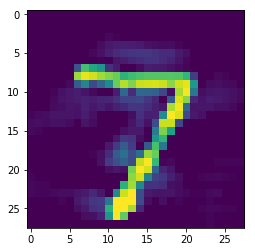

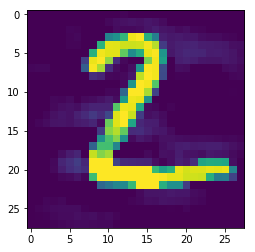

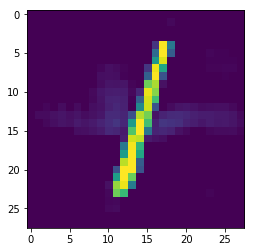

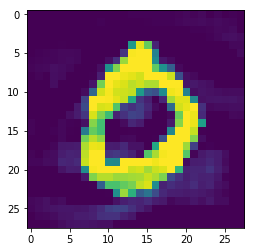

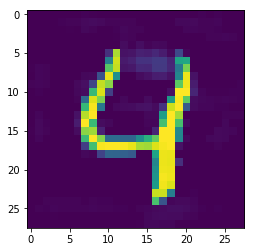

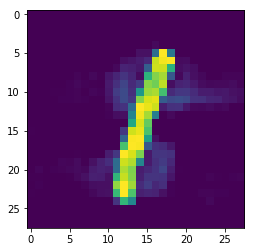

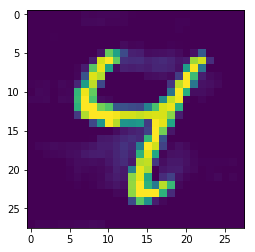

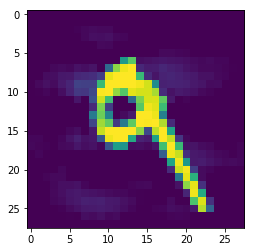

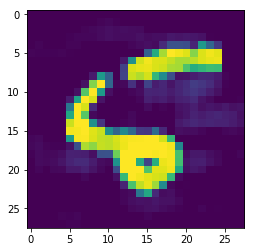

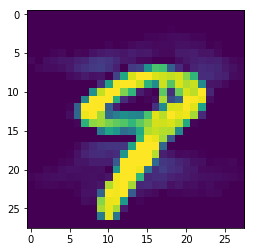

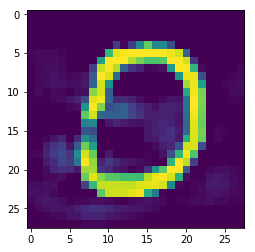

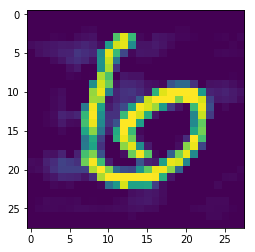

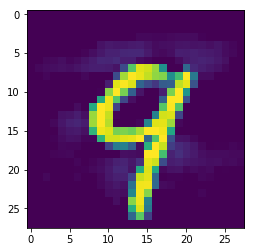

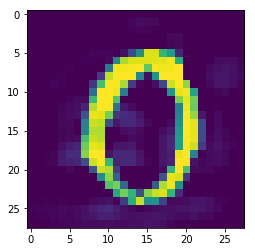

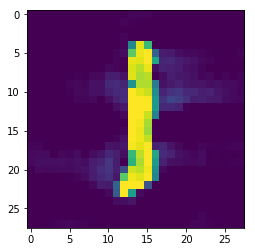

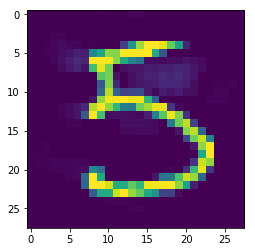

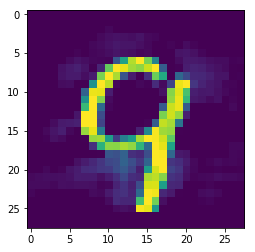

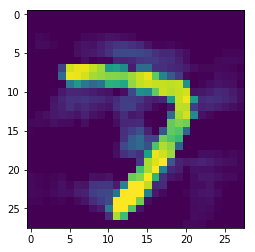

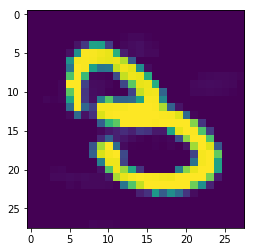

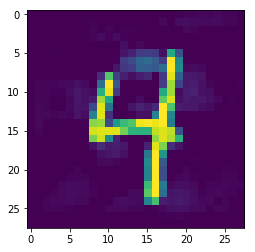

In [28]:
for i in range(20):
    plt.imshow(x_adv[i].view(28, 28).cpu().detach().numpy())
    plt.show()

In [4]:
# Subsamples dataset and reduces to two classes (1 and 7)
# Code adapted from https://github.com/yangarbiter/adversarial-nonparametrics

num_samples = 2200
num_val = 300 # can pick anything > 0, does not really get used here

from keras.datasets import mnist
(X, y), (_, _) = mnist.load_data()
np.random.seed(2019)
idx1 = np.random.choice(
    np.where(y == 1)[0], num_samples // 2, replace=False)
idx2 = np.random.choice(
    np.where(y == 7)[0], num_samples // 2, replace=False)
y[idx1] = 0
y[idx2] = 1
X = np.vstack((X[idx1], X[idx2])).astype(np.float32) / 255.
y = np.concatenate((y[idx1], y[idx2]))

idxs = np.arange(num_samples)
np.random.shuffle(idxs)
x_train_sub = torch.tensor(X[idxs[:-200]])
x_test_sub = torch.tensor(X[idxs[-200:]])
y_train_sub = torch.tensor(y[idxs[:-200]])
y_test_sub = torch.tensor(y[idxs[-200:]])

Using TensorFlow backend.


In [5]:
net_knn = KNNModel()

In [6]:
layers = ['identity']
knn = DKNNL2(net_knn, x_train_sub, y_train_sub, 
             x_test_sub, y_test_sub, layers, 
             k=1, num_classes=2)

In [7]:
with torch.no_grad():
    y_pred = knn.classify(x_test_sub)
    ind = np.where(y_pred.argmax(1) == y_test_sub.numpy())[0]
    print((y_pred.argmax(1) == y_test_sub.numpy()).sum() / y_test_sub.size(0))

0.99


In [56]:
# Attack for L2 DkNN

# attack = DKNNL2Attack()
# attack = DKNNLinfAttack()
from lib.dknn_attack_exp import DKNNExpAttack
attack = DKNNExpAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            knn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=1, binary_search_steps=15,
            max_iterations=1000, learning_rate=1e-1, guide_mode=1,
            initial_const=1e-2, abort_early=True, random_start=False)
    return x_adv

num = 200
x_adv = attack_batch(x_test_sub[:num].cuda(), y_test_sub[:num], 200)

    step: 0; loss: 0.454; l2dist: 0.000
tensor(2., device='cuda:0')
    step: 100; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 200; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 300; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 400; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 500; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 600; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 700; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 800; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 900; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
tensor(2., device='cuda:0')
binary step: 0; number of successful adv: 2/200
    step: 0; loss: 4.519; l2dist: 0.000
tensor(2., device='cuda:0')
    step: 100; loss: 4.229; l2dist: 0.483
tensor(3., device='cuda:0')
    step: 200; loss: 4.229; l2dist: 0.484
tensor(3., device='cuda:0')
    step: 300; los

In [57]:
with torch.no_grad():
    y_pred = knn.classify(x_adv)
    ind = np.where(y_pred.argmax(1) == y_test_sub[:num].numpy())[0]
    print(len(ind) / x_adv.size(0))

0.0


In [57]:
# knn.get_neighbors(x_test_sub[:10], k=50)
# for idx in knn.get_neighbors(x_test_sub[:10], k=50)[0][1]:
#     print(y_train_sub[idx])

[(array([[28.832077 , 35.470264 , 36.02511  , 37.656963 , 38.208473 ,
          39.263206 , 39.646885 , 40.205055 , 41.575085 , 42.94713  ,
          43.37243  , 43.766434 , 43.78415  , 43.83922  , 44.964108 ,
          45.238632 , 45.84772  , 46.177193 , 46.570705 , 47.616356 ,
          48.474632 , 48.639538 , 49.064854 , 49.434353 , 49.726173 ,
          50.41435  , 50.961292 , 51.059917 , 51.543686 , 51.673344 ,
          51.943703 , 52.586143 , 53.02256  , 53.0845   , 53.12081  ,
          53.513096 , 53.889782 , 54.112198 , 54.16712  , 55.332428 ,
          55.341377 , 55.519882 , 55.823795 , 56.449005 , 56.474342 ,
          56.536583 , 56.65898  , 57.060356 , 57.667496 , 57.79631  ],
         [ 2.9935718,  3.2781086,  3.3305187,  3.470542 ,  3.671557 ,
           3.8215458,  4.0873203,  4.5895424,  4.626682 ,  4.6806917,
           4.728166 ,  5.0415072,  5.0883045,  5.372903 ,  5.519185 ,
           5.5237226,  5.802368 ,  6.084614 ,  6.2640057,  6.362353 ,
           6.363291

In [34]:
y_test_sub[:3]

tensor([1, 0, 0], dtype=torch.uint8)

In [37]:
y_train_sub[1931]

tensor(0, dtype=torch.uint8)

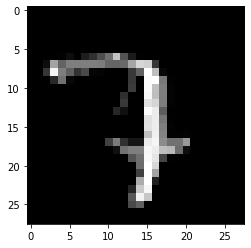

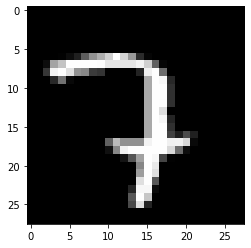

In [58]:
i = 8
plt.imshow(x_adv.cpu().detach().numpy()[i], cmap='gray')
plt.show()
plt.imshow(x_test_sub.cpu().detach().numpy()[i], cmap='gray')
plt.show()

In [58]:
(x_test_sub - x_adv.cpu()).view(num, -1).norm(2, 1).mean()

tensor(2.9113, grad_fn=<MeanBackward0>)

In [44]:
(x_test_sub - x_adv.cpu()).view(num, -1).min(1)

torch.return_types.min(
values=tensor([-0.4831, -0.4931, -0.4981, -0.4964, -0.4972, -0.4926, -0.4997, -0.4477,
        -0.4990, -0.4980, -0.4247, -0.4960, -0.4990, -0.4995, -0.4997, -0.4995,
        -0.4964, -0.4994, -0.4999, -0.4997, -0.4971, -0.4974, -0.4231, -0.4872,
        -0.4995, -0.4903, -0.5000, -0.4987, -0.4945, -0.4995, -0.4998, -0.4999,
        -0.4984, -0.4952, -0.5000, -0.4998, -0.4983, -0.4993, -0.4940, -0.4998,
        -0.4991, -0.4993, -0.4885, -0.4588, -0.4945, -0.4957, -0.4997, -0.4866,
        -0.4411, -0.4933, -0.4999, -0.4949, -0.5000, -0.4998, -0.4995, -0.3135,
        -0.4698, -0.4998, -0.5000, -0.4997, -0.4981, -0.4992, -0.4000, -0.4967,
        -0.4991, -0.4999, -0.4980, -0.4997, -0.4710, -0.4937, -0.4997, -0.4975,
        -0.4815, -0.4997, -0.4986, -0.4990, -0.4982, -0.4090, -0.4999, -0.4967,
        -0.4668, -0.4962, -0.4983, -0.4996, -0.4919, -0.4906, -0.4990, -0.4984,
        -0.4946, -0.4972, -0.4996, -0.4914, -0.4876, -0.4997, -0.4990, -0.4942,
        -